In [53]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = torch.device('cuda')
%matplotlib inline

In [272]:
class REncoder(nn.Module):
    def __init__(self, in_dim, out_dim, init_func = nn.init.normal_):
        super(REncoder, self).__init__()
        self.l1_size = 20
        
        self.l1 = nn.Linear(in_dim, self.l1_size)
        self.l2 = nn.Linear(self.l1_size, out_dim)
        self.a = nn.ReLU()
        
        if init_func is not None:
            init_func(self.l1.weight)
            init_func(self.l2.weight)
        
    def forward(self, inputs):
        return self.l2(self.a(self.l1(inputs)))

In [273]:
class ZEncoder(nn.Module):
    def __init__(self, in_dim, out_dim, init_func=nn.init.normal_):
        super(ZEncoder, self).__init__()
        self.m1_size = out_dim
        self.std1_size = out_dim
        
        self.m1 = nn.Linear(in_dim, self.m1_size)
        
        self.std1 = nn.Linear(in_dim, self.m1_size)
        
        if init_func is not None:
            init_func(self.m1.weight)
            init_func(self.std1.weight)
        
    def forward(self, inputs):
        softplus = nn.Softplus()
        return self.m1(inputs), softplus(self.std1(inputs))

In [274]:
class Decoder(nn.Module):
    def __init__(self, in_dim, out_dim, init_func=nn.init.normal_):
        super(Decoder, self).__init__()
        self.l1_size = 20
        self.l2_size = 20
        
        self.l1 = nn.Linear(in_dim, self.l1_size)
        self.l2 = nn.Linear(self.l1_size, out_dim)
        
        if init_func is not None:
            init_func(self.l1.weight)
            init_func(self.l2.weight)
        self.a = nn.Sigmoid()
    
    def forward(self, x_pred, z):
        zs_reshaped = z.unsqueeze(-1).expand(z.shape[0], z.shape[1], x_pred.shape[0]).transpose(1, 2)
        xpred_reshaped = x_pred.unsqueeze(0).expand(z.shape[0], x_pred.shape[0], x_pred.shape[1])
        xz = torch.cat([xpred_reshaped, zs_reshaped], dim=2)
        return self.l2(self.a(self.l1(xz))).squeeze(-1).transpose(0, 1), 0.005

In [275]:
def log_likelihood(mu, std, target):
    norm = torch.distributions.Normal(mu, std)
    return norm.log_prob(target).sum(dim=0).mean()

In [276]:
def KLD_gaussian(mu_q, std_q, mu_p, std_p):
    qs2 = std_q**2 + 1e-16
    ps2 = std_p**2 + 1e-16
    return (qs2/ps2 + ((mu_q - mu_p)**2)/ps2 + torch.log(ps2/qs2) - 1.0).sum()*0.5

In [277]:
r_dim = 2
z_dim = 2
x_dim = 1
y_dim = 1

n_z_samples = 10
repr_encoder = REncoder(x_dim + y_dim, r_dim).cuda()
z_encoder = ZEncoder(r_dim, z_dim).cuda()
decoder = Decoder(x_dim + z_dim, y_dim).cuda()

opt = torch.optim.Adam(list(decoder.parameters()) + list(z_encoder.parameters()) + list(repr_encoder.parameters()),
                       lr=1e-1)

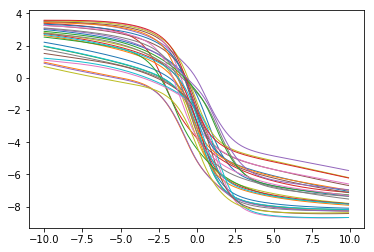

In [278]:
x_grid = torch.from_numpy(np.arange(-10, 10, 0.1).reshape(-1, 1).astype(np.float32)).cuda()

untrained_zs = torch.from_numpy(np.random.normal(size=(30, z_dim)).astype(np.float32)).cuda()
mu, sigma = decoder(x_grid, untrained_zs)
for i in range(mu.shape[1]):
    plt.plot(x_grid.data.cpu().numpy(), mu[:, i].data.cpu().numpy(), linewidth=1)
#     plt.fill_between(
#     x_grid.data.numpy(), mu[:, i].data.numpy() - sigma[:, i].data.numpy()**2,
#     mu[:, i].data.numpy() + sigma[:, i].data.numpy()**2,
#     alpha=0.2)
plt.show()

In [279]:
def random_split_context_target(x, y, n_context):
    ind = np.arange(x.shape[0])
    mask = np.random.choice(ind, size=n_context, replace=False)
    return x[mask], y[mask], np.delete(x, mask, axis=0), np.delete(y, mask, axis=0)

def sample_z(mu, std, n):
    eps = torch.autograd.Variable(std.data.new(n, z_dim).normal_())
    return mu + std * eps

def data_to_z_params(x, y):
    xy = torch.cat([x, y], dim=1)
    rs = repr_encoder(xy)
    r_agg = rs.mean(dim=0)
    return z_encoder(r_agg)

def visualize(x, y, x_star):
    z_mu, z_std = data_to_z_params(x, y)
    zsamples = sample_z(z_mu, z_std, 100)
    mu, sigma = decoder(x_star, zsamples)
    for i in range(mu.shape[1]):
        plt.plot(x_star.data.cpu().numpy(), mu[:,i].data.cpu().numpy(), linewidth=1)
#     plt.fill_between(
#         x_grid.data.cpu().numpy(), mu[:, i].data.cpu().numpy() - sigma**2,
#         mu[:, i].data.cpu().numpy() + sigma**2,
#         alpha=0.2)
    plt.scatter(x.data.cpu().numpy(), y.data.cpu().numpy())
    plt.show()

In [280]:
all_x_np = np.arange(-10, 10, 1.0).reshape(-1, 1).astype(np.float32)
all_y_np = np.exp(np.cos(all_x_np))**3 - 2*np.sin(all_x_np)

In [281]:
def train(n_epochs, n_display=1000):
    losses = []
    for t in range(n_epochs):
        opt.zero_grad()
        x_context, y_context, x_target, y_target = random_split_context_target(
        all_x_np, all_y_np, np.random.randint(1, 4))
        
        x_c = torch.from_numpy(x_context).cuda()
        x_t = torch.from_numpy(x_target).cuda()
        y_c = torch.from_numpy(y_context).cuda()
        y_t = torch.from_numpy(y_target).cuda()
        
        x_ct = torch.cat([x_c, x_t], dim=0)
        y_ct = torch.cat([y_c, y_t], dim=0)
        
        z_mean_all, z_std_all = data_to_z_params(x_ct, y_ct)
        z_mean_context, z_std_context = data_to_z_params(x_c, y_c)
        
        zs = sample_z(z_mean_all, z_std_all, n_z_samples)
        mu, std = decoder(x_t, zs)
        loss = - log_likelihood(mu, std, y_t) + KLD_gaussian(z_mean_all, z_std_all, z_mean_context, z_std_context)
        losses.append(loss.item())
        loss.backward()
        opt.step()
        if t % n_display ==0:
            print("Function samples after {} steps:".format(t))
            x_g = torch.from_numpy(np.arange(-10,10, 0.1).reshape(-1,1).astype(np.float32)).cuda()
            visualize(x_ct, y_ct, x_g)

Function samples after 0 steps:


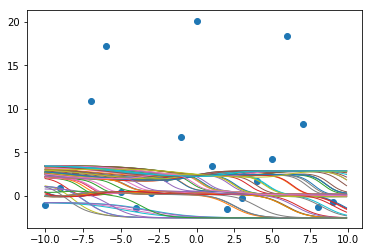

Function samples after 1000 steps:


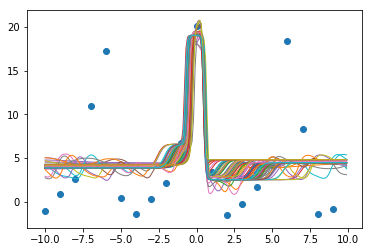

Function samples after 2000 steps:


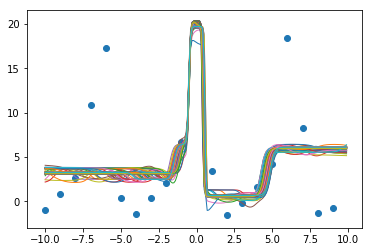

Function samples after 3000 steps:


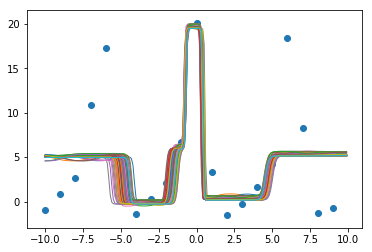

Function samples after 4000 steps:


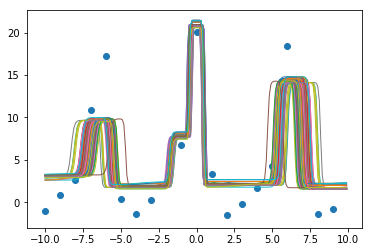

Function samples after 5000 steps:


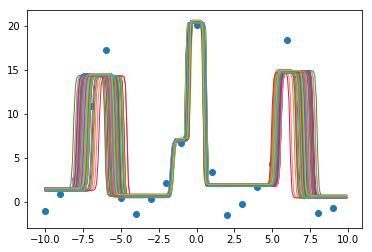

Function samples after 6000 steps:


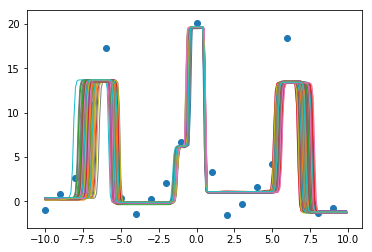

Function samples after 7000 steps:


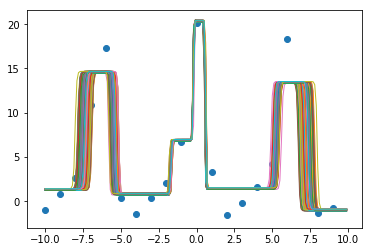

Function samples after 8000 steps:


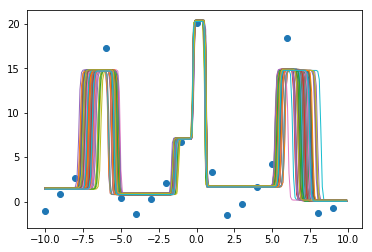

Function samples after 9000 steps:


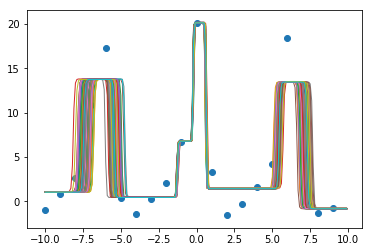

Function samples after 10000 steps:


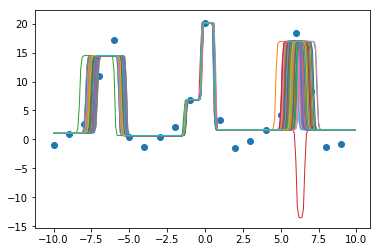

Function samples after 11000 steps:


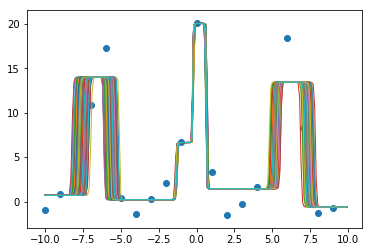

Function samples after 12000 steps:


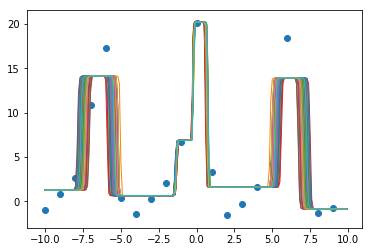

Function samples after 13000 steps:


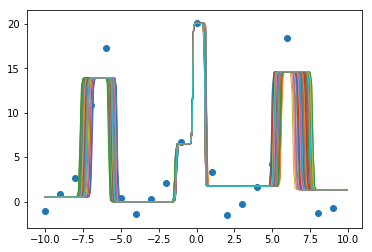

Function samples after 14000 steps:


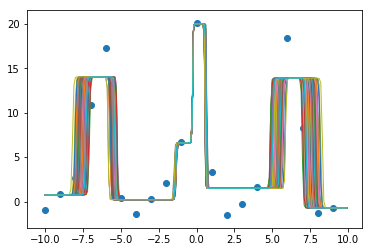

Function samples after 15000 steps:


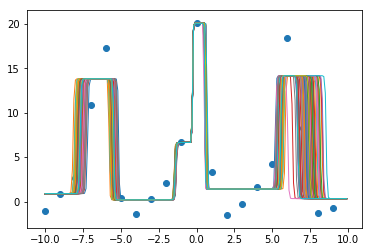

Function samples after 16000 steps:


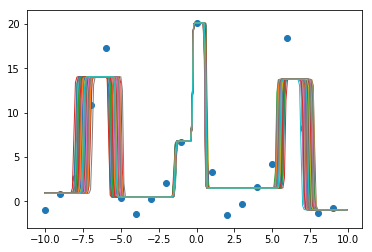

Function samples after 17000 steps:


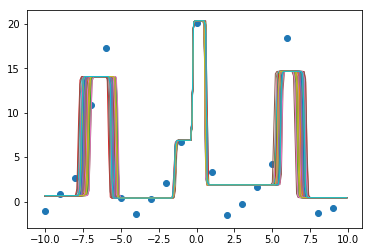

Function samples after 18000 steps:


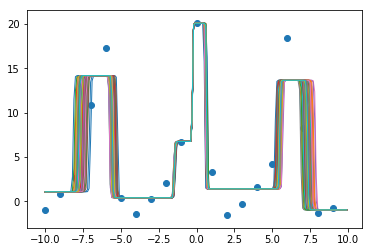

Function samples after 19000 steps:


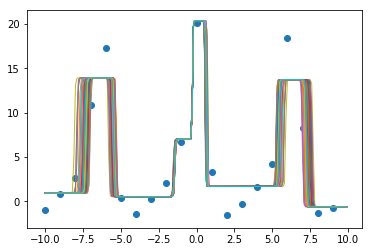

Function samples after 20000 steps:


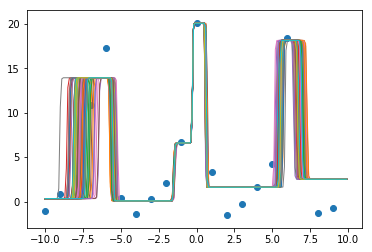

Function samples after 21000 steps:


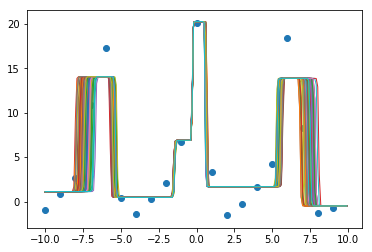

Function samples after 22000 steps:


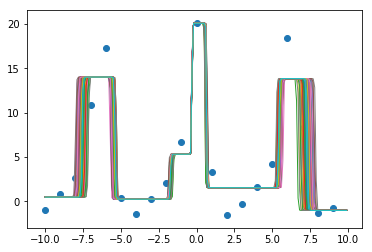

Function samples after 23000 steps:


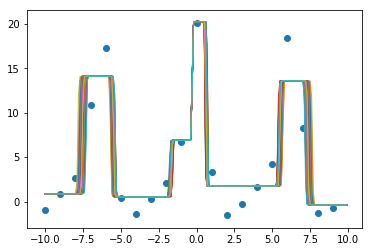

Function samples after 24000 steps:


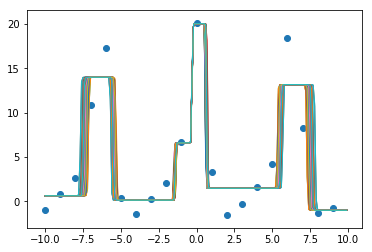

Function samples after 25000 steps:


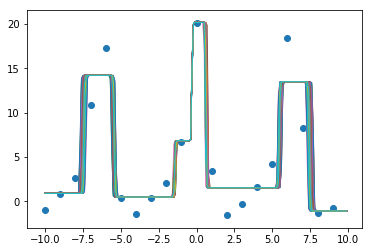

Function samples after 26000 steps:


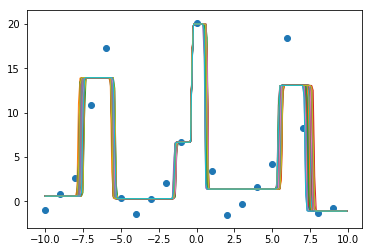

Function samples after 27000 steps:


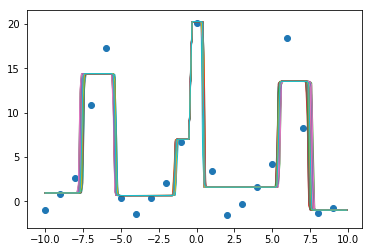

Function samples after 28000 steps:


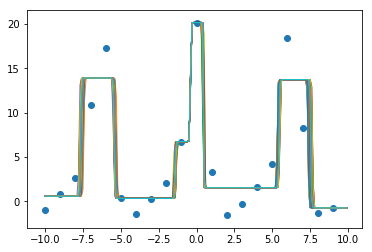

Function samples after 29000 steps:


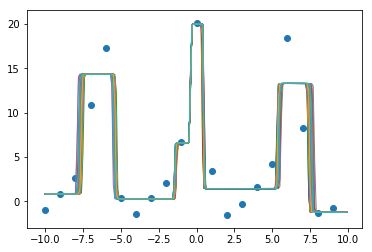

Function samples after 30000 steps:


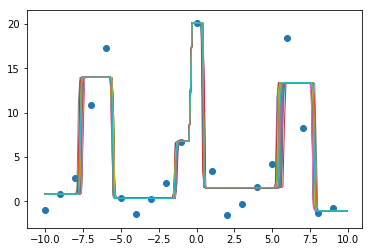

Function samples after 31000 steps:


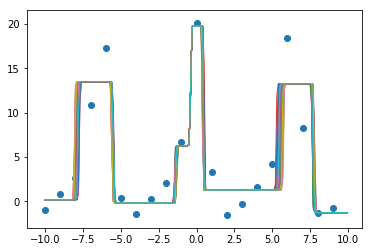

Function samples after 32000 steps:


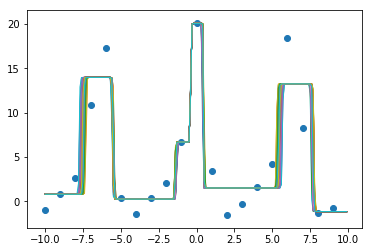

Function samples after 33000 steps:


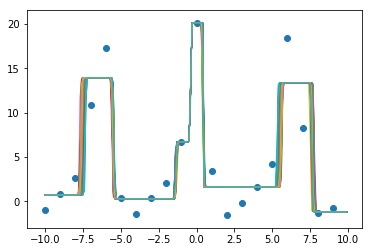

Function samples after 34000 steps:


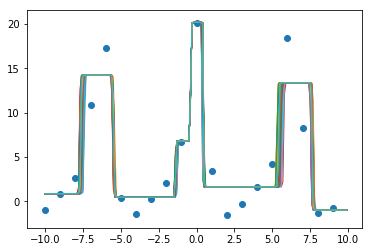

Function samples after 35000 steps:


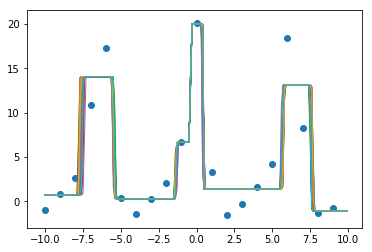

Function samples after 36000 steps:


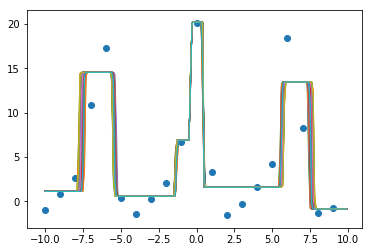

Function samples after 37000 steps:


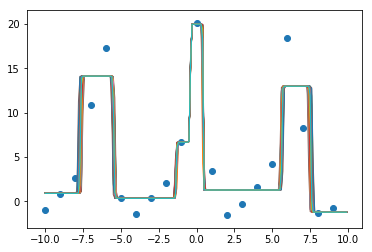

Function samples after 38000 steps:


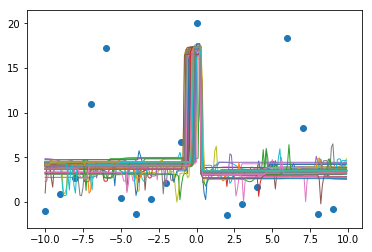

Function samples after 39000 steps:


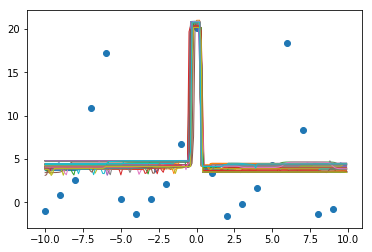

Function samples after 40000 steps:


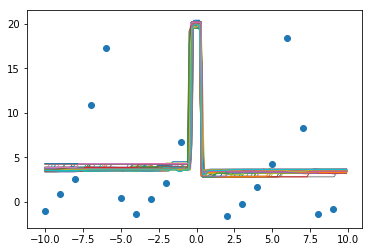

Function samples after 41000 steps:


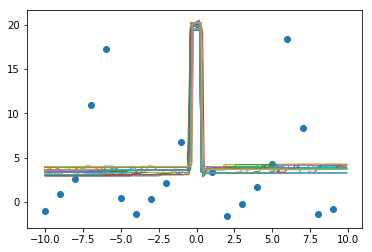

Function samples after 42000 steps:


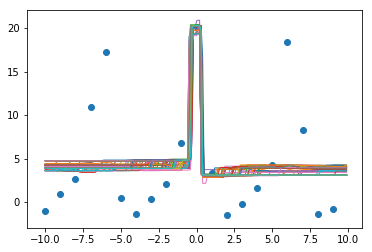

Function samples after 43000 steps:


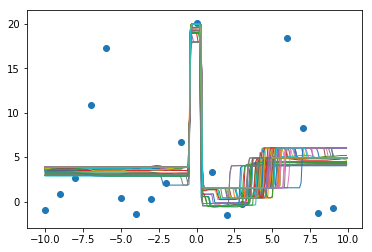

Function samples after 44000 steps:


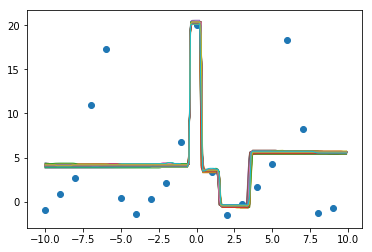

Function samples after 45000 steps:


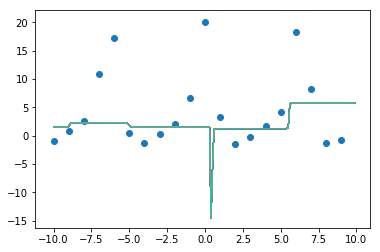

Function samples after 46000 steps:


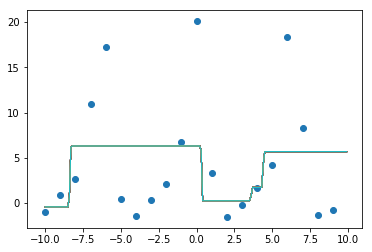

Function samples after 47000 steps:


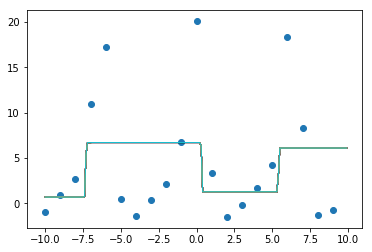

Function samples after 48000 steps:


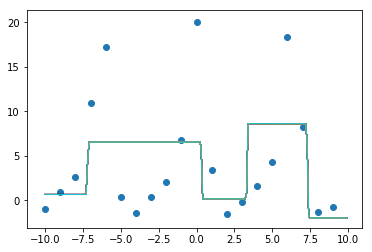

Function samples after 49000 steps:


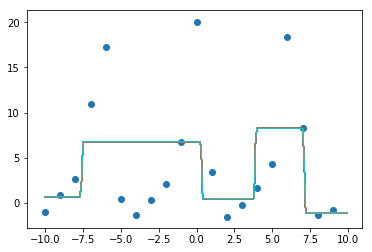

Function samples after 50000 steps:


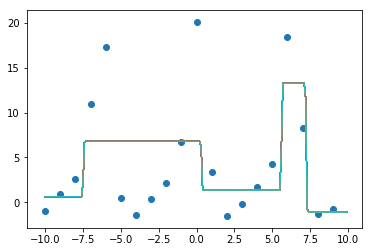

Function samples after 51000 steps:


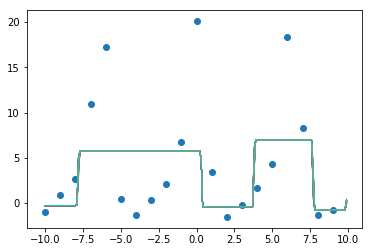

Function samples after 52000 steps:


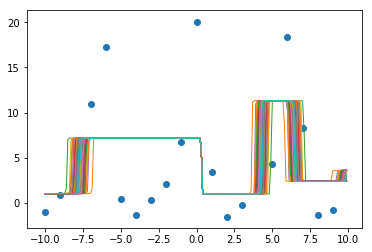

Function samples after 53000 steps:


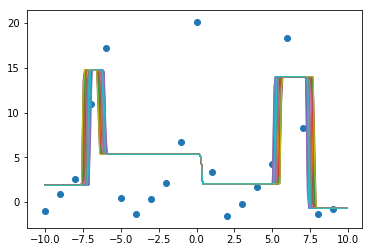

Function samples after 54000 steps:


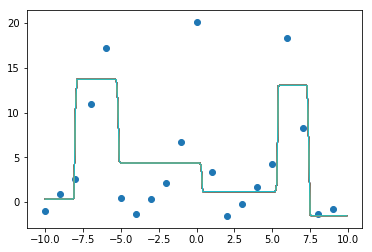

Function samples after 55000 steps:


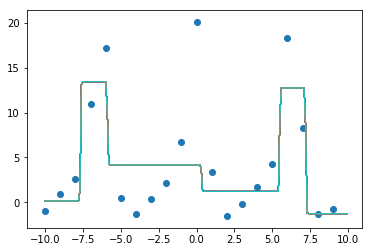

Function samples after 56000 steps:


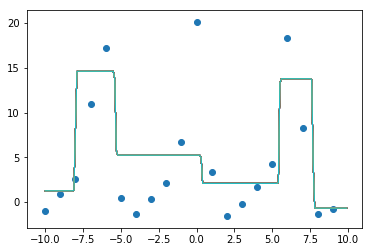

Function samples after 57000 steps:


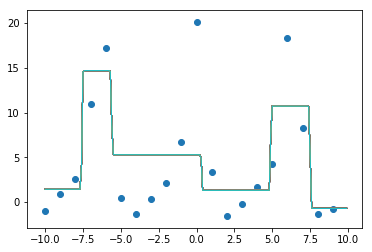

Function samples after 58000 steps:


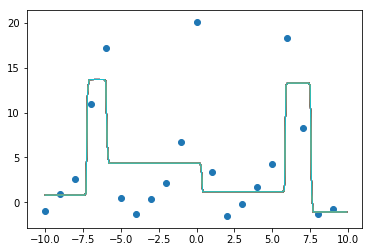

Function samples after 59000 steps:


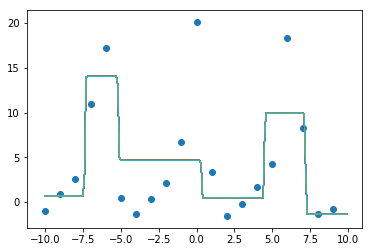

Function samples after 60000 steps:


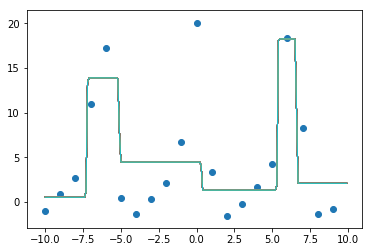

Function samples after 61000 steps:


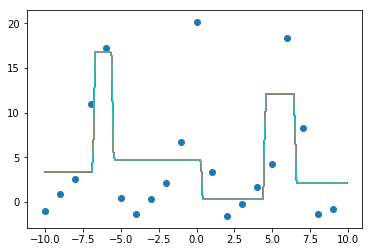

Function samples after 62000 steps:


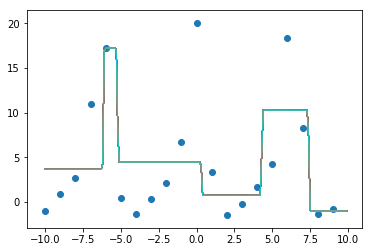

Function samples after 63000 steps:


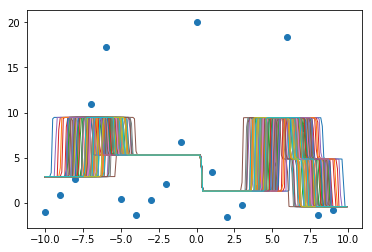

Function samples after 64000 steps:


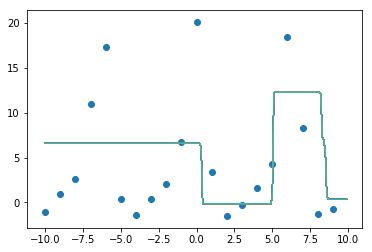

Function samples after 65000 steps:


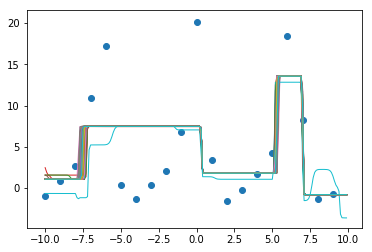

Function samples after 66000 steps:


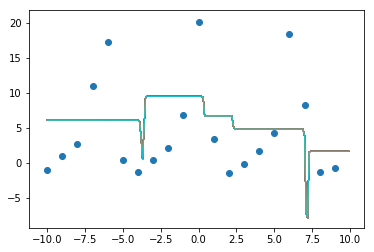

Function samples after 67000 steps:


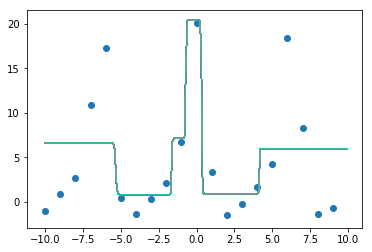

Function samples after 68000 steps:


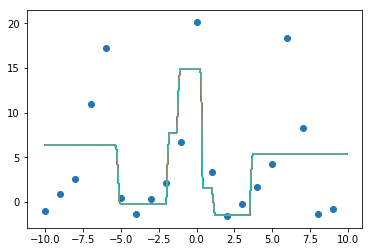

Function samples after 69000 steps:


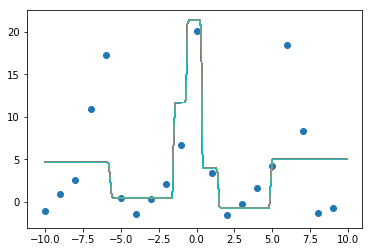

Function samples after 70000 steps:


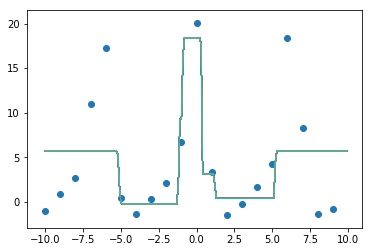

Function samples after 71000 steps:


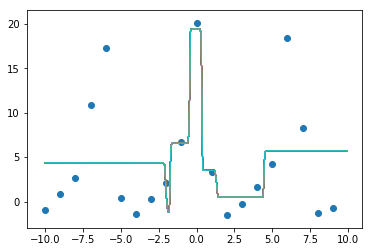

Function samples after 72000 steps:


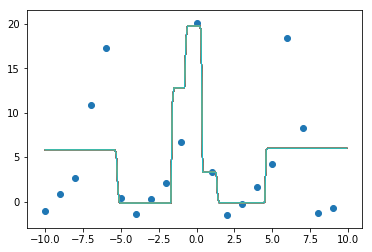

Function samples after 73000 steps:


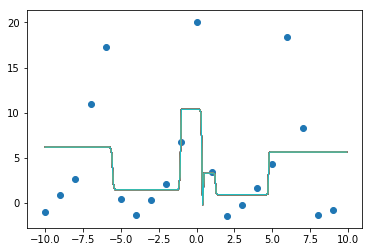

Function samples after 74000 steps:


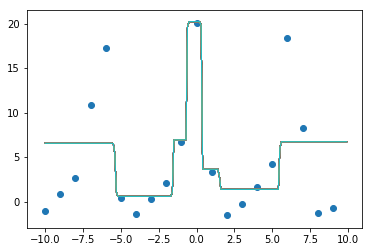

Function samples after 75000 steps:


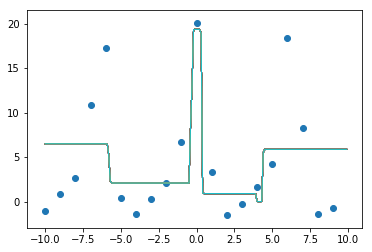

Function samples after 76000 steps:


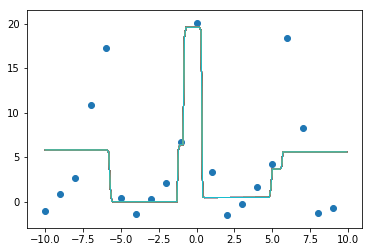

Function samples after 77000 steps:


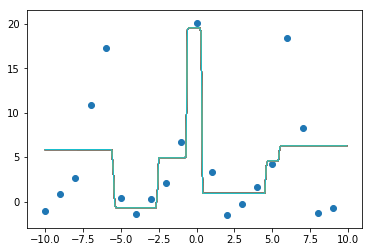

Function samples after 78000 steps:


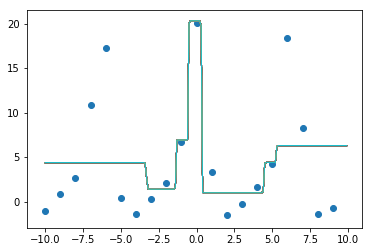

Function samples after 79000 steps:


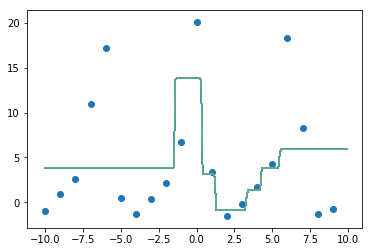

In [282]:
train(80000)